# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [126]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from time import time

Let's load and show the camera frame.

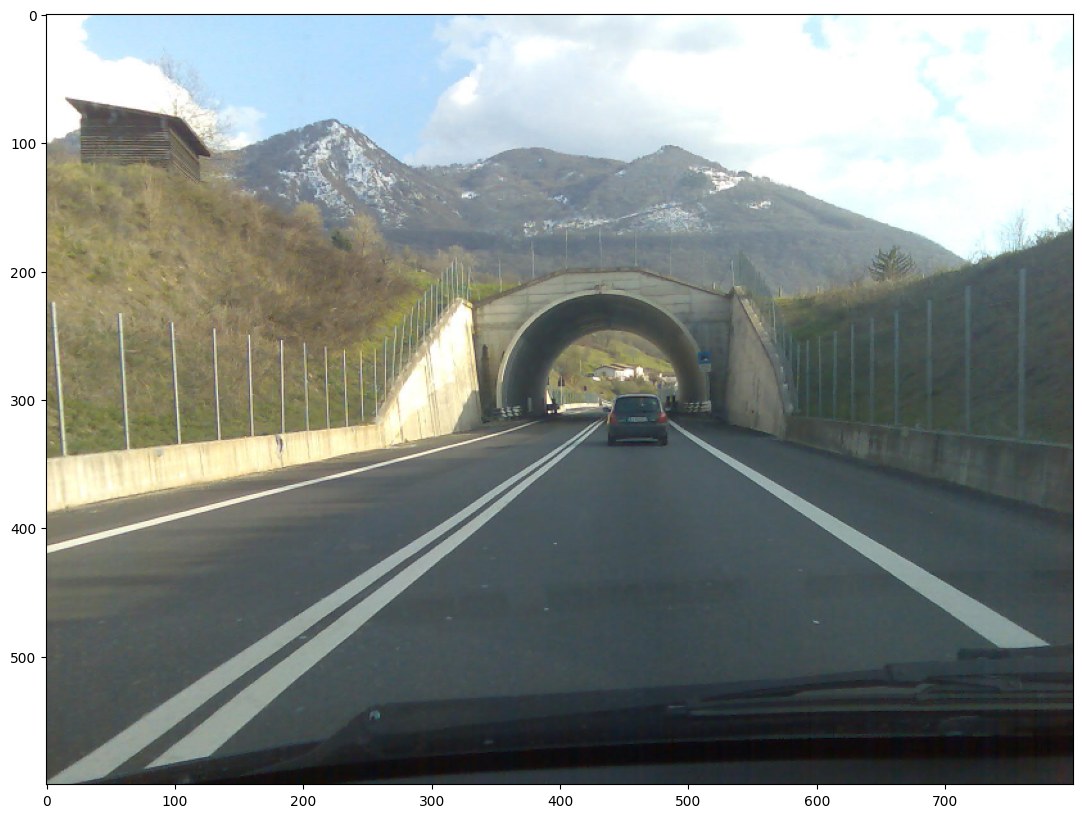

In [127]:
img = cv2.imread('../data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [128]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [129]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interested in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

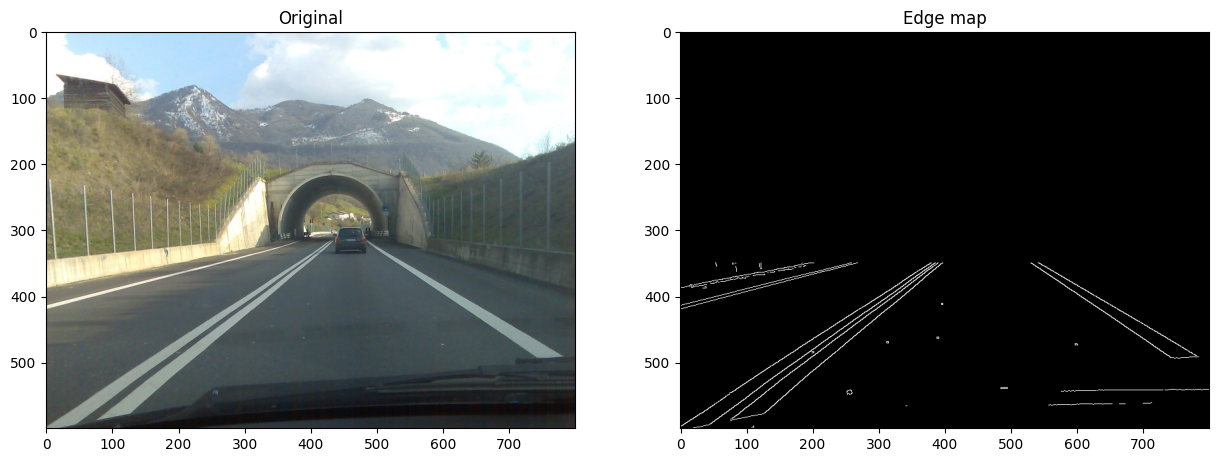

In [130]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [177]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
start = time()
lines = cv2.HoughLines(edges, rho=1, theta=1*np.pi/180, threshold=150)
print('Elapsed time:', time() - start)
# Let's get rid of the unnecessary dimension
print(lines.shape)
lines = lines[:, 0, :]
print(lines.shape)

Elapsed time: 0.0016660690307617188
(10, 1, 2)
(10, 2)


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

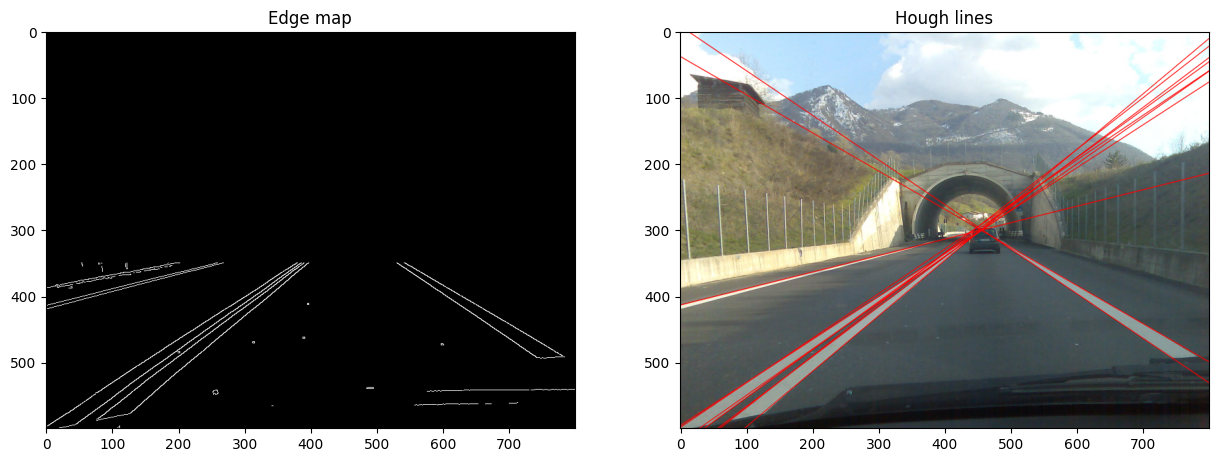

In [178]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [179]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []

dgr_2_rdn = np.pi/180
horizontal = 90 * dgr_2_rdn
delta = 20 * dgr_2_rdn

theta_low = horizontal - delta
theta_high = horizontal + delta

for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    # Keep line if theta is not horizontal
    if not (theta_low < theta < theta_high):
        filtered_lines.append(line)

print(lines.shape, len(filtered_lines))

(10, 2) 9


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

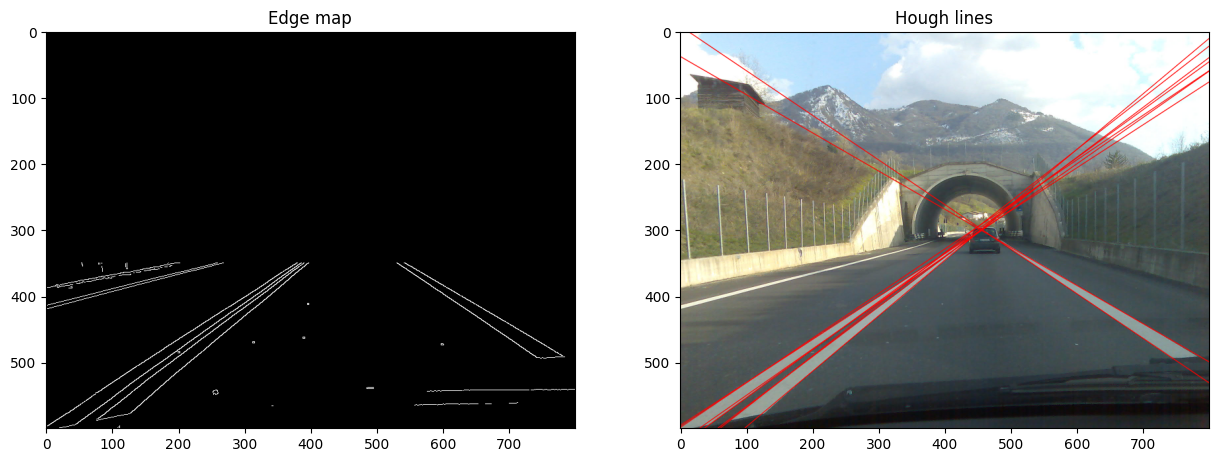

In [181]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [182]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[ -7.        ,   2.16420817],
       [507.5       ,   0.95120442],
       [ 33.        ,   2.09439516],
       [522.        ,   0.87266463],
       [498.        ,   0.98611102],
       [511.5       ,   0.91629785]])

True

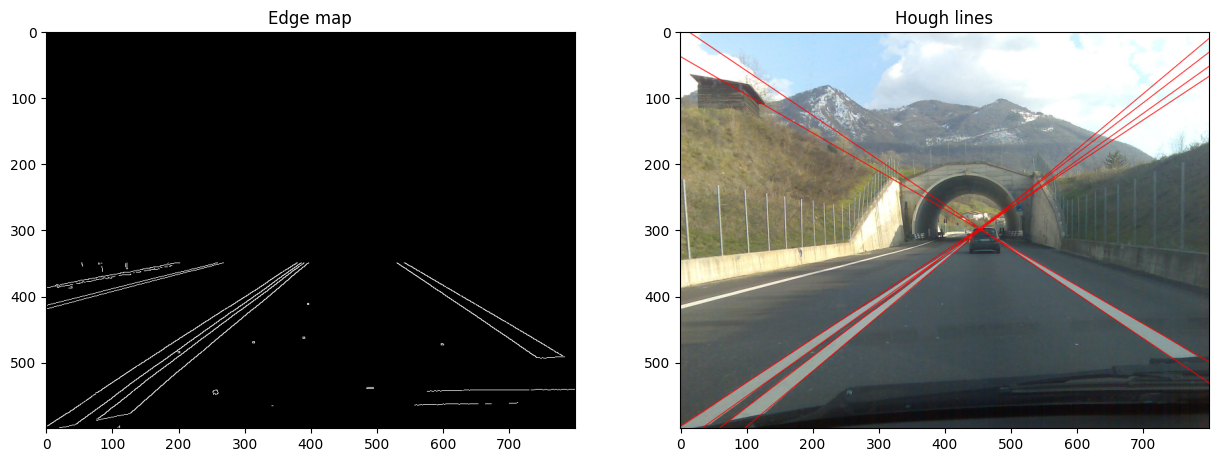

In [183]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

# Save the result image for further analysis
#result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
#cv2.imwrite('../data/1-1-150.jpg', result)

### Questions
* Do you see anything strange in the final result?

A: Yes, taking recommended 2-2-190 params for Hough transform we kind of mess up the lane edges a little as I will show below.

* Do you think the Hough transform resolution is important for obtaining a good result? Why?
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

A: As always there is no such thing as a free lunch ;) Basically it's a tradeoff between computation cost and accuracy.

Lower resolution (higher values for rho and theta) and higher threshold (such as 2-2-190) costs less and detects only the most clearly defined features.
Higher resolution and lower threshold (1-1-15) takes more times to compute (1-1-15 is 2-3 times slower than 2-2-190) and relies more on post-processing such as K-means clustering, but does a better job accuracy wise.

Comparison below highlights the difference in accuracy:

(<Axes: title={'center': 'rho=1, theta=1, threshold=150'}>,
 Text(0.5, 1.0, 'rho=1, theta=1, threshold=150'))

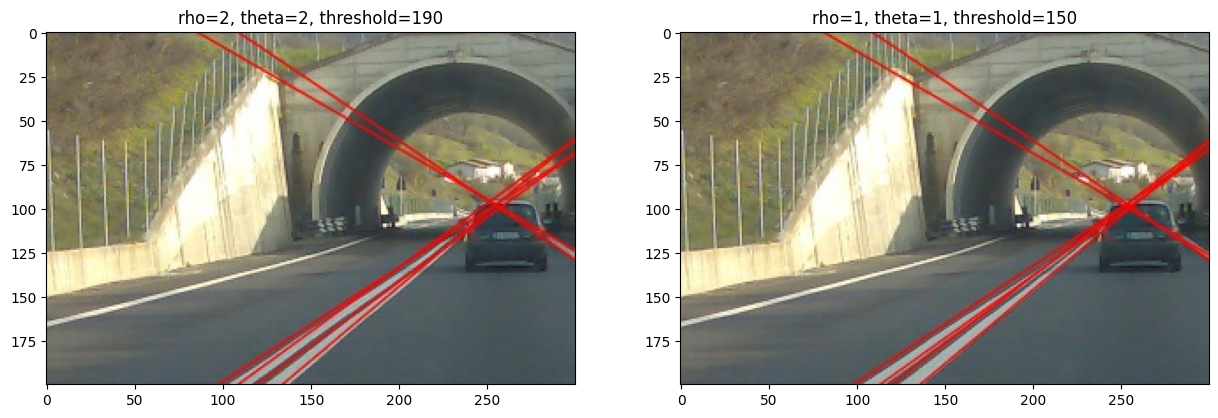

In [186]:
img1 = cv2.imread('../data/2-2-190.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('../data/1-1-150.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(img1[200:400, 200:500, :], cmap='gray'), plt.title('rho=2, theta=2, threshold=190')
plt.subplot(122), plt.imshow(img2[200:400, 200:500, :], cmap='gray'), plt.title('rho=1, theta=1, threshold=150')
